In [13]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models  # Added for pretrained models

# For reproducibility
torch.manual_seed(1234)
np.random.seed(1234)

print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"CUDA Device Name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA Available: True
CUDA Device Name: NVIDIA GeForce RTX 4050 Laptop GPU


In [14]:
# Custom Dataset class to apply transforms
class TransformedDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        img, label = self.subset[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

In [15]:
data_dir = "256_ObjectCategories"
full_dataset = datasets.ImageFolder(root=data_dir)
num_classes = len(full_dataset.classes)
print(f"Found {num_classes} classes.")

# Split dataset
indices = list(range(len(full_dataset)))
stratify = np.array(full_dataset.targets)
train_val_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=1234, stratify=stratify)
train_idx, val_idx = train_test_split(train_val_idx, test_size=0.2, random_state=1234, stratify=stratify[train_val_idx])

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
val_test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = TransformedDataset(Subset(full_dataset, train_idx), transform=train_transform)
val_dataset = TransformedDataset(Subset(full_dataset, val_idx), transform=val_test_transform)
test_dataset = TransformedDataset(Subset(full_dataset, test_idx), transform=val_test_transform)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0, pin_memory=True, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=0, pin_memory=True, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=0, pin_memory=True, shuffle=False)

Found 257 classes.


In [16]:
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedCNN, self).__init__()
        # Feature extraction
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))
        )
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
            )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Justification:
# - Additional conv layer (512 filters) to capture more complex patterns
# - Adaptive pooling to handle varying spatial dimensions
# - Increased dropout for better regularization
# - More linear layers with dropout for better classification

In [18]:
model = ImprovedCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# Early stopping parameters
patience = 7
best_val_loss = float('inf')
epochs_no_improve = 0
num_epochs = 30

Epoch 1/30: Train Loss=5.1786 | Train Acc=7.44% | Val Loss=4.7845 | Val Acc=9.90%
Epoch 2/30: Train Loss=4.7136 | Train Acc=11.26% | Val Loss=4.4065 | Val Acc=13.70%
Epoch 3/30: Train Loss=4.4327 | Train Acc=13.78% | Val Loss=4.2020 | Val Acc=17.89%
Epoch 4/30: Train Loss=4.1815 | Train Acc=16.70% | Val Loss=3.9506 | Val Acc=20.11%
Epoch 5/30: Train Loss=3.9595 | Train Acc=19.64% | Val Loss=3.7699 | Val Acc=23.24%
Epoch 6/30: Train Loss=3.7766 | Train Acc=22.19% | Val Loss=3.6200 | Val Acc=25.95%
Epoch 7/30: Train Loss=3.5911 | Train Acc=24.11% | Val Loss=3.4619 | Val Acc=27.73%
Epoch 8/30: Train Loss=3.4679 | Train Acc=25.89% | Val Loss=3.3306 | Val Acc=30.12%
Epoch 9/30: Train Loss=3.3435 | Train Acc=27.85% | Val Loss=3.3252 | Val Acc=30.06%
Epoch 10/30: Train Loss=3.2382 | Train Acc=30.18% | Val Loss=3.2502 | Val Acc=31.41%
Epoch 11/30: Train Loss=3.1260 | Train Acc=31.26% | Val Loss=3.1436 | Val Acc=32.82%
Epoch 12/30: Train Loss=3.0453 | Train Acc=32.65% | Val Loss=3.0655 | Val Ac

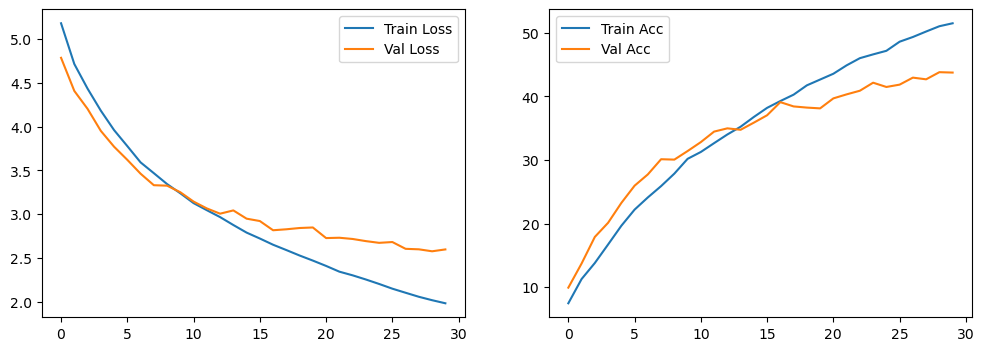

<All keys matched successfully>

In [19]:
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    acc = 100. * correct / total
    return train_loss / len(train_loader.dataset), acc

def validate(model, device, val_loader, criterion):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    acc = 100. * correct / total
    return val_loss / len(val_loader.dataset), acc

# Training loop
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(1, num_epochs+1):
    train_loss, train_acc = train(model, device, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model, device, val_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    print(f"Epoch {epoch}/{num_epochs}: "
          f"Train Loss={train_loss:.4f} | Train Acc={train_acc:.2f}% | "
          f"Val Loss={val_loss:.4f} | Val Acc={val_acc:.2f}%")
    
    scheduler.step(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch} epochs.")
            break

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.savefig('training_history.png')
plt.show()

model.load_state_dict(torch.load('best_model.pth'))

In [20]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average='weighted', zero_division=0
)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")

Test Accuracy: 0.4417
Test Precision: 0.4513
Test Recall: 0.4417
Test F1-Score: 0.4259


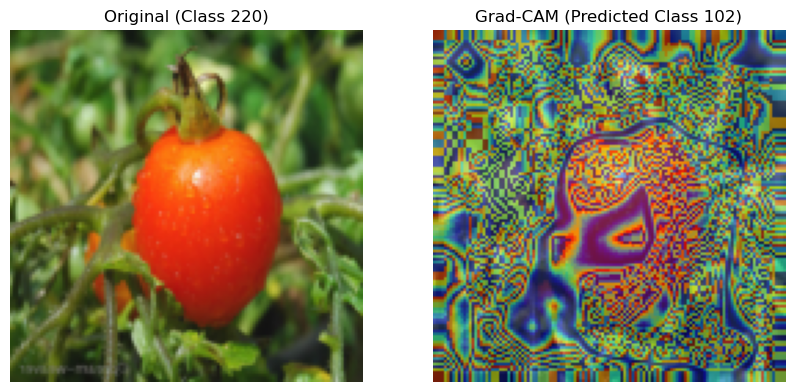

In [21]:
model.eval()
cam_extractor = GradCAM(model, target_layer='features.12')  # Target last conv layer

# Get a sample batch
sample_images, sample_labels = next(iter(test_loader))
sample_image = sample_images[0:1].to(device)
sample_label = sample_labels[0].item()

# Generate CAM
out = model(sample_image)
pred_class = out.argmax(dim=1)[0].item()
activation_map = cam_extractor(pred_class, out)[0].squeeze(0).cpu().numpy()

# Normalize and resize activation map
activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())
activation_map = Image.fromarray(activation_map * 255).convert('L')
activation_map = activation_map.resize((128, 128), Image.BILINEAR)
activation_map = np.array(activation_map) / 255.0

# Denormalize image
img_np = sample_image[0].cpu().permute(1, 2, 0).numpy()
img_np = (img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])).clip(0, 1)

# Overlay and show
cam_overlay = overlay_mask(
    Image.fromarray((img_np * 255).astype(np.uint8)),
    Image.fromarray((activation_map * 255).astype(np.uint8)),
    alpha=0.5
)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title(f'Original (Class {sample_label})')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(cam_overlay)
plt.title(f'Grad-CAM (Predicted Class {pred_class})')
plt.axis('off')
plt.savefig('gradcam_example.png')
plt.show()

# Grad-CAM Explanation:
# - Fixed interpolation using PIL instead of torch.nn.functional
# - Targeted the last convolutional layer for richer features
# - Improved normalization and visualization